In [ ]:
%pip install xgboost lightgbm tensorflow

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.72.1-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using 

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Users\\tycon\\miniconda3\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thêm cho Optuna hyperparameter tuning
try:
    import optuna
    print("Optuna đã được cài đặt!")
except ImportError:
    print("Cần cài đặt Optuna: pip install optuna")

import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Kiểm tra GPU availability
print("Đã import thành công các thư viện cần thiết!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("GPU được phát hiện! Sẽ sử dụng GPU cho training.")
else:
    print("Không phát hiện GPU. Sử dụng CPU.")

Đã import thành công các thư viện cần thiết!
TensorFlow version: 2.19.0


In [4]:
# Đọc dữ liệu FPT.csv
df = pd.read_csv('FPT.csv')
print(f"Đã đọc dữ liệu FPT: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(df.head())

Đã đọc dữ liệu FPT: (97406, 8)
Columns: ['Ticker', 'Date/Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest']
  Ticker        Date/Time   Open   High    Low  Close  Volume  Open Interest
0    FPT  12/25/2018 9:15  30.89  30.89  30.89  30.89   35410              0
1    FPT  12/25/2018 9:16  30.81  30.81  30.81  30.81     190              0
2    FPT  12/25/2018 9:17  30.74  30.81  30.74  30.74    1120              0
3    FPT  12/25/2018 9:18  30.74  30.74  30.74  30.74    2120              0
4    FPT  12/25/2018 9:19  30.74  30.74  30.74  30.74   22500              0


In [5]:
# Khám phá dữ liệu chi tiết
print("=== PHÂN TÍCH DỮ LIỆU FPT ===")
print(f"Shape: {df.shape}")
print(f"\nThông tin cột:")
print(df.info())
print(f"\nThống kê mô tả:")
print(df.describe())
print(f"\nGiá trị null:")
print(df.isnull().sum())

=== PHÂN TÍCH DỮ LIỆU FPT ===
Shape: (97406, 8)

Thông tin cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB
None

Thống kê mô tả:
               Open          High           Low         Close        Volume  \
count  97406.000000  97406.000000  97406.000000  97406.000000  9.740600e+04   
mean      45.071630     45.090138     45.051430     45.071631  8.044173e+03   
std        6.359803      6.364950      6.354245      6.359799  1.75

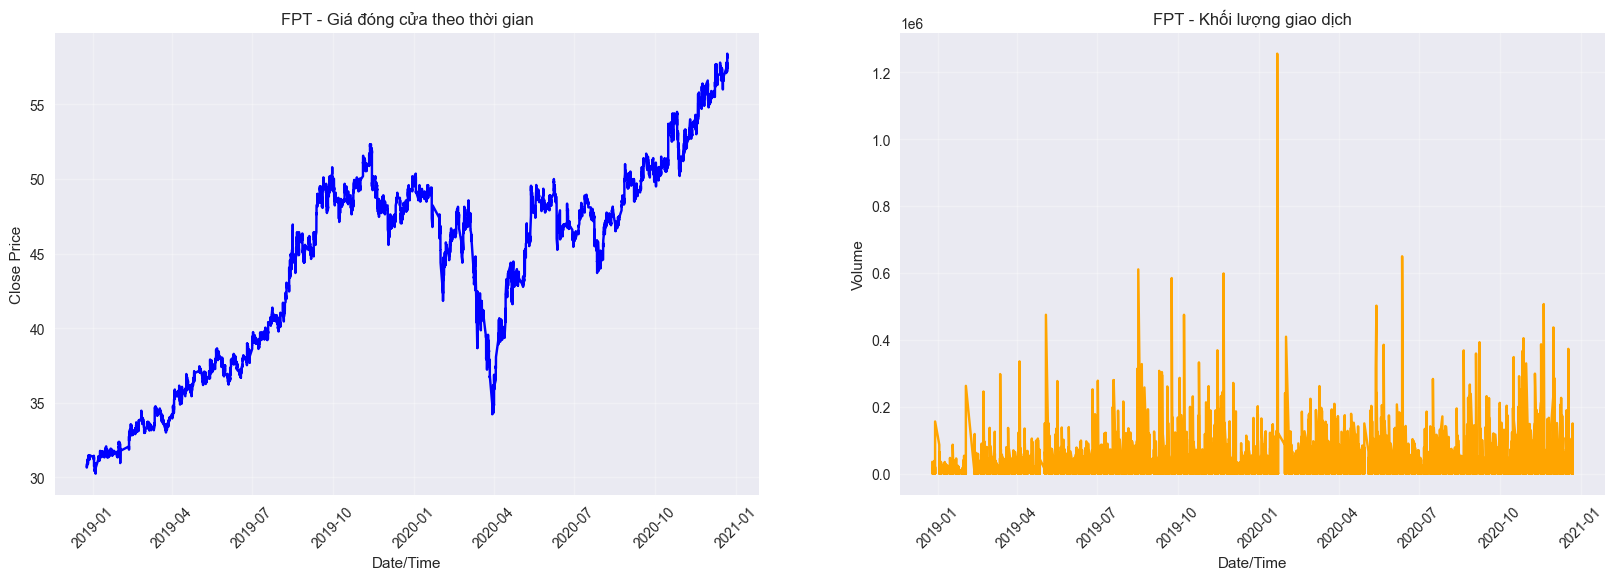

In [36]:
# Vẽ biểu đồ dữ liệu FPT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Biểu đồ giá Close
ax1.plot(df['Date/Time'], df['Close'], label='FPT Close Price', color='blue')
ax1.set_title('FPT - Giá đóng cửa theo thời gian')
ax1.set_xlabel('Date/Time')
ax1.set_ylabel('Close Price')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Biểu đồ khối lượng
ax2.plot(df['Date/Time'], df['Volume'], label='Volume', color='orange')
ax2.set_title('FPT - Khối lượng giao dịch')
ax2.set_xlabel('Date/Time')
ax2.set_ylabel('Volume')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# plt.tight_layout()
plt.show()

In [7]:
# Xử lý cột thời gian
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df = df.sort_values('Date/Time')
df = df.reset_index(drop=True)
print(f"Đã xử lý cột thời gian: Date/Time")

Đã xử lý cột thời gian: Date/Time


In [31]:
# Tạo target variable: biến động giá
df['Price'] = df['Close']

# Biến động giá 1 kỳ sau
df['Price_Next'] = df['Price'].shift(-1)
df['Price_Change'] = df['Price_Next'] - df['Price']
df['Price_Change_Pct'] = (df['Price_Change'] / df['Price']) * 100

print("Đã tạo biến target:")
print(f"- Price_Change: Biến động giá tuyệt đối")
print(f"- Price_Change_Pct: Biến động giá phần trăm")
print(f"\nThống kê biến động giá:")
print(df['Price_Change_Pct'].describe())

Đã tạo biến target:
- Price_Change: Biến động giá tuyệt đối
- Price_Change_Pct: Biến động giá phần trăm

Thống kê biến động giá:
count    97405.000000
mean         0.000749
std          0.141430
min         -5.820750
25%          0.000000
50%          0.000000
75%          0.000000
max          3.617571
Name: Price_Change_Pct, dtype: float64


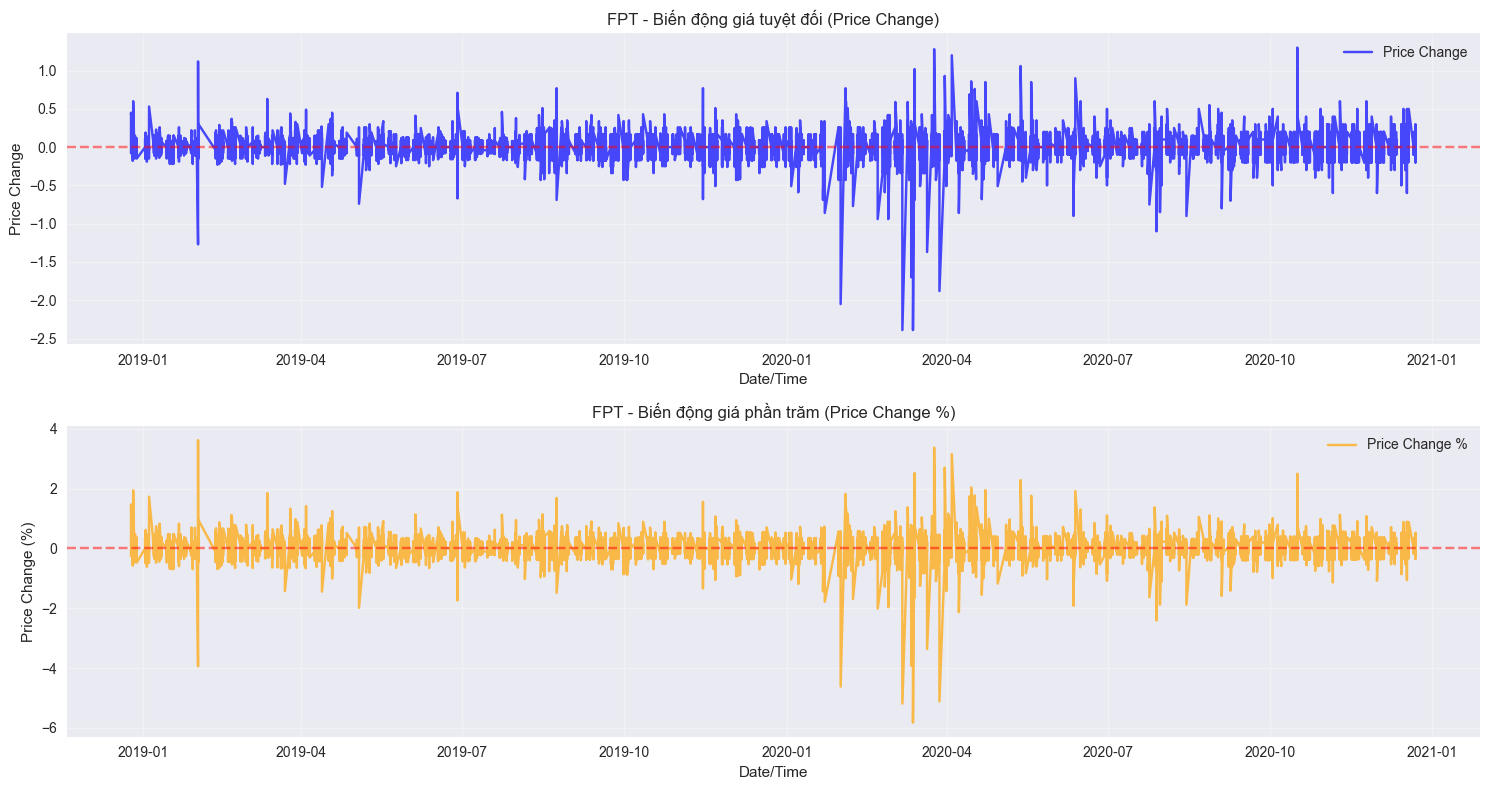

=== THỐNG KÊ BIẾN ĐỘNG GIÁ ===

Price_Change (tuyệt đối):
count    97405.000000
mean         0.000279
std          0.063485
min         -2.390000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.300000
Name: Price_Change, dtype: float64

Price_Change_Pct (phần trăm):
count    97405.000000
mean         0.000749
std          0.141430
min         -5.820750
25%          0.000000
50%          0.000000
75%          0.000000
max          3.617571
Name: Price_Change_Pct, dtype: float64


In [37]:
# Vẽ biểu đồ Price_Change và Price_Change_Pct
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Biểu đồ Price_Change (biến động giá tuyệt đối)
ax1.plot(df['Date/Time'], df['Price_Change'], label='Price Change', color='blue', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('FPT - Biến động giá tuyệt đối (Price Change)')
ax1.set_xlabel('Date/Time')
ax1.set_ylabel('Price Change')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ Price_Change_Pct (biến động giá phần trăm)
ax2.plot(df['Date/Time'], df['Price_Change_Pct'], label='Price Change %', color='orange', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('FPT - Biến động giá phần trăm (Price Change %)')
ax2.set_xlabel('Date/Time')
ax2.set_ylabel('Price Change (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("=== THỐNG KÊ BIẾN ĐỘNG GIÁ ===")
print("\nPrice_Change (tuyệt đối):")
print(df['Price_Change'].describe())
print("\nPrice_Change_Pct (phần trăm):")
print(df['Price_Change_Pct'].describe())

In [39]:
# Tạo các features kỹ thuật - Moving Averages
for window in [5, 10, 20]:
    df[f'MA_{window}'] = df['Price'].rolling(window=window).mean()
    df[f'Price_MA_{window}_Ratio'] = df['Price'] / df[f'MA_{window}']

print("Đã tạo Moving Averages:")
print("- MA_5, MA_10, MA_20")
print("- Price_MA_5_Ratio, Price_MA_10_Ratio, Price_MA_20_Ratio")

Đã tạo Moving Averages:
- MA_5, MA_10, MA_20
- Price_MA_5_Ratio, Price_MA_10_Ratio, Price_MA_20_Ratio


In [40]:
# Tạo RSI (Relative Strength Index)
delta = df['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

print("Đã tạo RSI (Relative Strength Index)")
print(f"RSI trung bình: {df['RSI'].mean():.2f}")

Đã tạo RSI (Relative Strength Index)
RSI trung bình: 50.08


In [41]:
# Tạo Volatility và Price momentum
df['Volatility'] = df['Price'].rolling(window=10).std()

# Price momentum
for lag in [1, 3, 5]:
    df[f'Price_Lag_{lag}'] = df['Price'].shift(lag)
    df[f'Return_{lag}'] = (df['Price'] / df[f'Price_Lag_{lag}'] - 1) * 100

print("Đã tạo:")
print("- Volatility: Độ biến động")
print("- Return_1, Return_3, Return_5: Returns với lag khác nhau")

Đã tạo:
- Volatility: Độ biến động
- Return_1, Return_3, Return_5: Returns với lag khác nhau


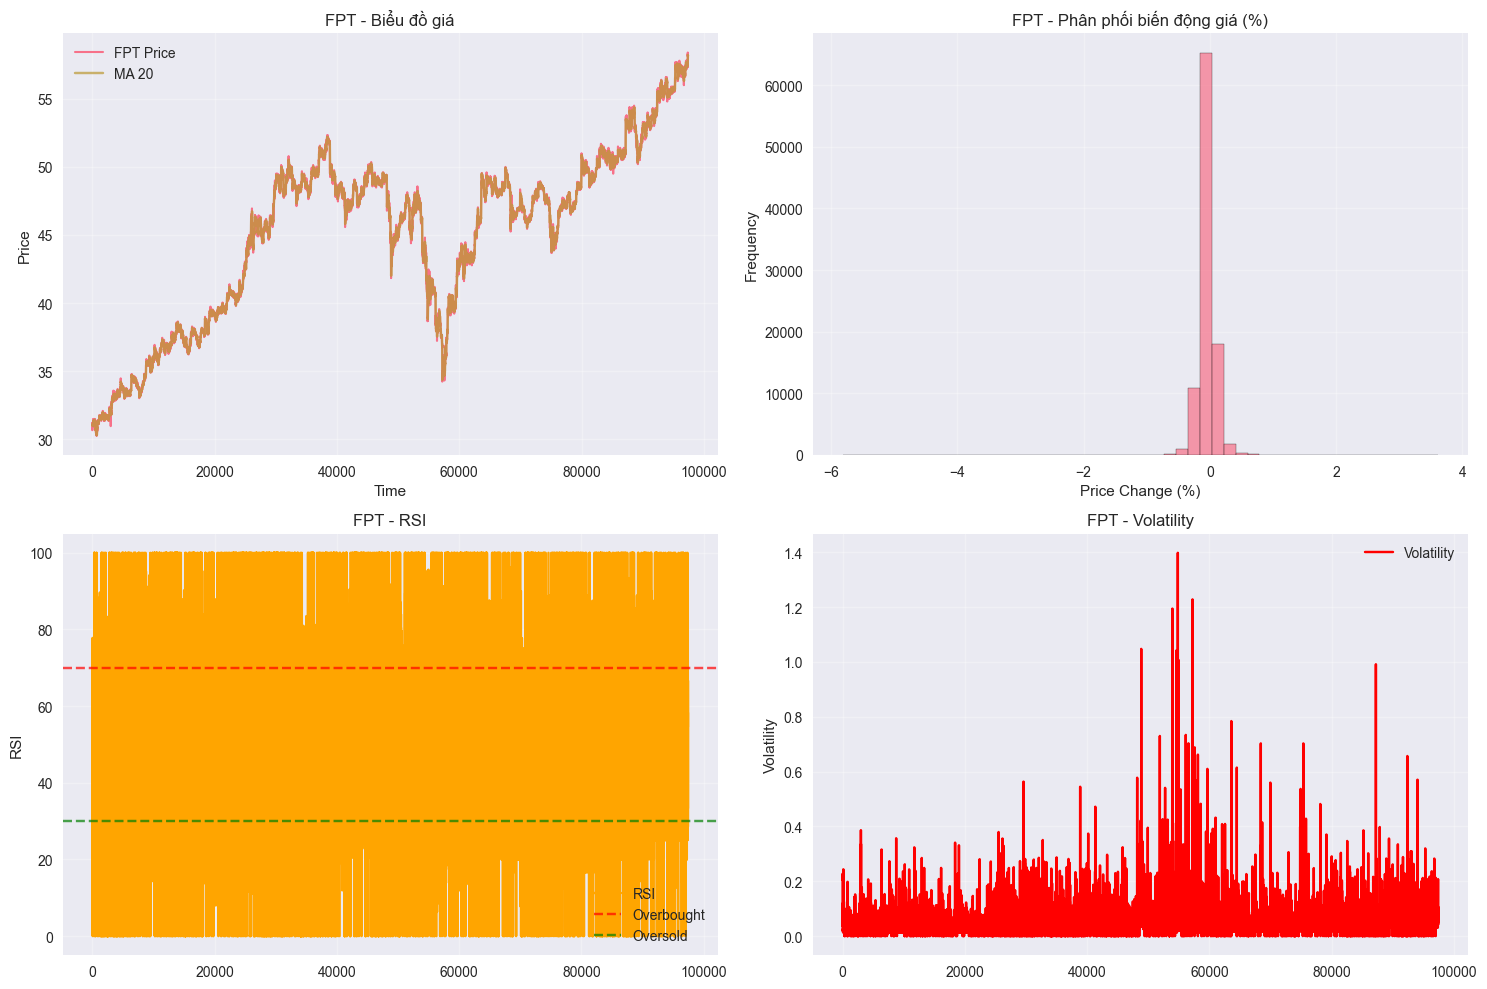

In [42]:
# Visualization dữ liệu
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Biểu đồ giá
axes[0,0].plot(df.index, df['Price'], label='FPT Price', linewidth=1.5)
if 'MA_20' in df.columns:
    axes[0,0].plot(df.index, df['MA_20'], label='MA 20', alpha=0.7)
axes[0,0].set_title('FPT - Biểu đồ giá')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Price')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Phân phối biến động giá
df['Price_Change_Pct'].dropna().hist(bins=50, ax=axes[0,1], alpha=0.7, edgecolor='black')
axes[0,1].set_title('FPT - Phân phối biến động giá (%)')
axes[0,1].set_xlabel('Price Change (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# RSI
axes[1,0].plot(df.index, df['RSI'], label='RSI', color='orange')
axes[1,0].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
axes[1,0].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
axes[1,0].set_title('FPT - RSI')
axes[1,0].set_ylabel('RSI')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Volatility
axes[1,1].plot(df.index, df['Volatility'], label='Volatility', color='red')
axes[1,1].set_title('FPT - Volatility')
axes[1,1].set_ylabel('Volatility')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== TOP FEATURES CORRELATION với Price_Change_Pct ===
Price_Change_Pct     1.000000
Price_Change         0.989825
Return_1             0.165034
Price_MA_5_Ratio     0.112511
Return_3             0.083726
Price_MA_10_Ratio    0.078156
Price_MA_20_Ratio    0.062820
Return_5             0.057576
RSI                  0.053214
Volume               0.029814
Name: Price_Change_Pct, dtype: float64


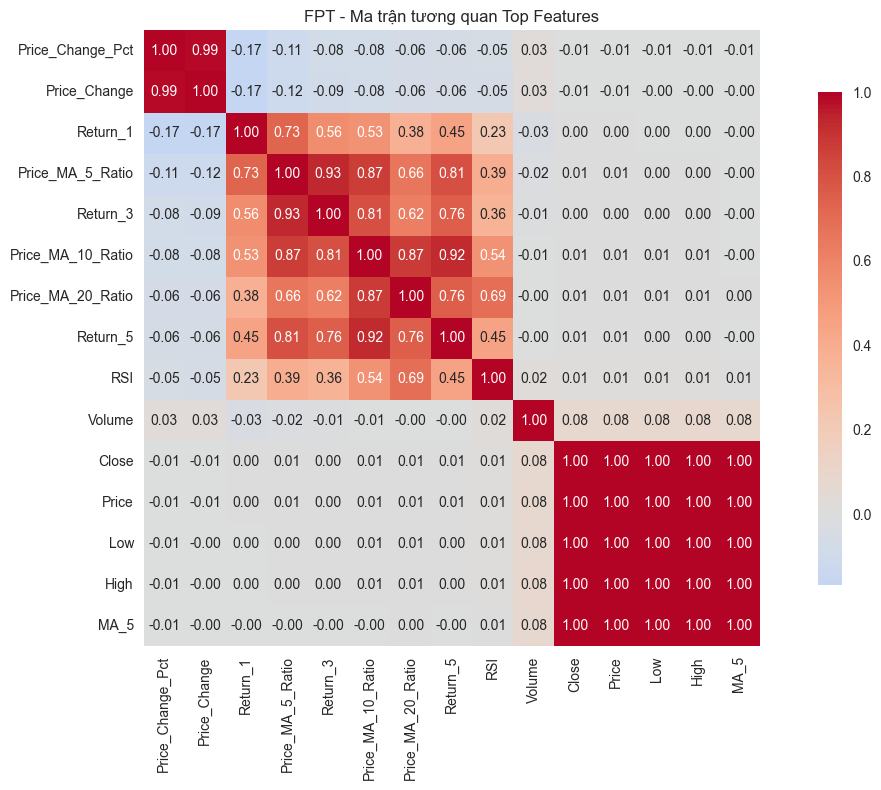

In [43]:
# Phân tích correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_df = df[numeric_cols].dropna()

if 'Price_Change_Pct' in numeric_df.columns:
    correlations = numeric_df.corr()['Price_Change_Pct'].abs().sort_values(ascending=False)
    
    print("=== TOP FEATURES CORRELATION với Price_Change_Pct ===")
    print(correlations.head(10))
    
    # Vẽ correlation matrix
    plt.figure(figsize=(12, 8))
    top_features = correlations.head(15).index
    corr_matrix = numeric_df[top_features].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('FPT - Ma trận tương quan Top Features')
    plt.tight_layout()
    plt.show()

In [44]:
# Chuẩn bị dữ liệu cho machine learning
target_col = 'Price_Change_Pct'
exclude_cols = [target_col, 'Price_Next', 'Price_Change']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Tạo dataset
ml_df = df[feature_cols + [target_col]].dropna()
print(f"Dataset sau khi loại bỏ NaN: {ml_df.shape}")

X = ml_df[feature_cols]
y = ml_df[target_col]

# Chia train/test theo thời gian (80/20)
split_idx = int(len(ml_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")

Dataset sau khi loại bỏ NaN: (96673, 22)
Training set: (77338, 21)
Test set: (19335, 21)
Features: 21
Feature names: ['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest', 'Price', 'MA_5', 'Price_MA_5_Ratio', 'MA_10', 'Price_MA_10_Ratio', 'MA_20', 'Price_MA_20_Ratio', 'RSI', 'Volatility', 'Price_Lag_1', 'Return_1', 'Price_Lag_3', 'Return_3', 'Price_Lag_5', 'Return_5']


In [45]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Đã chuẩn hóa dữ liệu bằng StandardScaler")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Đã chuẩn hóa dữ liệu bằng StandardScaler
X_train_scaled shape: (77338, 21)
X_test_scaled shape: (19335, 21)


In [ ]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# # Mô hình 1: Random Forest với GridSearchCV

# # Time Series Cross Validation
# tscv = TimeSeriesSplit(n_splits=5)

# # Grid search parameters để chống overfitting
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [10, 20, 50],
#     'min_samples_leaf': [5, 10, 20],
#     'max_features': ['sqrt', 'log2', 0.5]
# }

# # Base model với regularization mạnh hơn
# rf_base = RandomForestRegressor(
#     random_state=42,
#     bootstrap=True,
#     oob_score=True
# )

# # GridSearchCV
# rf_grid = GridSearchCV(
#     rf_base, 
#     param_grid, 
#     cv=tscv,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )

# rf_grid.fit(X_train_scaled, y_train)

# # Best parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}
# # Best CV score: 0.0197

# # Best model
# rf_model = rf_grid.best_estimator_
# print(f"Best parameters: {rf_grid.best_params_}")
# print(f"Best CV score: {-rf_grid.best_score_:.4f}")

# rf_train_pred = rf_model.predict(X_train_scaled)
# rf_test_pred = rf_model.predict(X_test_scaled)

# # Đánh giá
# rf_train_r2 = r2_score(y_train, rf_train_pred)
# rf_test_r2 = r2_score(y_test, rf_test_pred)
# rf_train_mse = mean_squared_error(y_train, rf_train_pred)
# rf_test_mse = mean_squared_error(y_test, rf_test_pred)
# rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
# rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

# print(f"\nRandom Forest Results (Optimized):")
# print(f"  Train R²: {rf_train_r2:.4f}")
# print(f"  Test R²: {rf_test_r2:.4f}")
# print(f"  Train MSE: {rf_train_mse:.4f}")
# print(f"  Test MSE: {rf_test_mse:.4f}")
# print(f"  Train MAE: {rf_train_mae:.4f}")
# print(f"  Test MAE: {rf_test_mae:.4f}")

# # Random Forest Results (Optimized):
# #   Train R²: 0.1225
# #   Test R²: 0.0969
# #   Train MSE: 0.0181
# #   Test MSE: 0.0163
# #   Train MAE: 0.0792
# #   Test MAE: 0.0839

=== TRAINING RANDOM FOREST với GridSearchCV ===
Đang thực hiện GridSearchCV...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}
Best CV score: 0.0197

Random Forest Results (Optimized):
  Train R²: 0.1225
  Test R²: 0.0969
  Train MSE: 0.0181
  Test MSE: 0.0163
  Train MAE: 0.0792
  Test MAE: 0.0839


In [ ]:
# Mô hình 2: XGBoost với GridSearchCV và GPU
print("=== TRAINING XGBOOST WITH GRIDSEARCH ===")

# Check GPU availability for XGBoost
try:
    import xgboost as xgb
    # Test GPU support
    gpu_available = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    gpu_available.fit([[1]], [1])
    print("GPU available for XGBoost!")
    tree_method = 'gpu_hist'
    gpu_id = 0
except:
    print("GPU not available for XGBoost, using CPU")
    tree_method = 'hist'
    gpu_id = None

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Base XGBoost model
if gpu_id is not None:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method=tree_method,
        gpu_id=gpu_id,
        verbosity=0
    )
else:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method=tree_method,
        verbosity=0
    )

# GridSearchCV for XGBoost
xgb_grid = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Starting XGBoost GridSearch...")
xgb_grid.fit(X_train_scaled, y_train)

# Best XGBoost model
xgb_model = xgb_grid.best_estimator_
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost CV score: {-xgb_grid.best_score_:.4f}")

# Dự đoán
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

# Đánh giá
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)
xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)

print(f"\nXGBoost Results (Optimized):")
print(f"  Train R²: {xgb_train_r2:.4f}")
print(f"  Test R²: {xgb_test_r2:.4f}")
print(f"  Train MSE: {xgb_train_mse:.4f}")
print(f"  Test MSE: {xgb_test_mse:.4f}")
print(f"  Train MAE: {xgb_train_mae:.4f}")
print(f"  Test MAE: {xgb_test_mae:.4f}")

=== TRAINING XGBOOST ===
XGBoost Results:
  Train R²: 0.4347
  Test R²: -0.1518
  Train MSE: 0.0116
  Test MSE: 0.0208
  Train MAE: 0.0731
  Test MAE: 0.1014
XGBoost Results:
  Train R²: 0.4347
  Test R²: -0.1518
  Train MSE: 0.0116
  Test MSE: 0.0208
  Train MAE: 0.0731
  Test MAE: 0.1014


In [ ]:
# Mô hình 3: LightGBM với Optuna (tối ưu hơn GridSearch cho LightGBM)
print("=== TRAINING LIGHTGBM WITH OPTUNA OPTIMIZATION ===")

# Install optuna if not available
try:
    import optuna
    print("Optuna available!")
except ImportError:
    print("Installing Optuna...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna

# Check GPU support for LightGBM
try:
    import lightgbm as lgb
    # Test GPU
    test_model = lgb.LGBMRegressor(device='gpu', gpu_platform_id=0, gpu_device_id=0)
    test_model.fit([[1]], [1])
    print("GPU available for LightGBM!")
    device_type = 'gpu'
except:
    print("GPU not available for LightGBM, using CPU")
    device_type = 'cpu'

# Optuna objective function
def lgb_objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': device_type,
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Time series cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train_scaled):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMRegressor(**params)
        model.fit(X_fold_train, y_fold_train)
        pred = model.predict(X_fold_val)
        score = mean_squared_error(y_fold_val, pred)
        scores.append(score)
    
    return np.mean(scores)

# Create study and optimize
print("Starting LightGBM optimization with Optuna...")
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lgb_objective, n_trials=100, timeout=600)  # 10 minutes max

print(f"Best LightGBM parameters: {study.best_params}")
print(f"Best LightGBM CV score: {study.best_value:.4f}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'device': device_type,
    'verbosity': -1,
    'random_state': 42
})

lgb_model = LGBMRegressor(**best_params)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán
lgb_train_pred = lgb_model.predict(X_train_scaled)
lgb_test_pred = lgb_model.predict(X_test_scaled)

# Đánh giá
lgb_train_r2 = r2_score(y_train, lgb_train_pred)
lgb_test_r2 = r2_score(y_test, lgb_test_pred)
lgb_train_mse = mean_squared_error(y_train, lgb_train_pred)
lgb_test_mse = mean_squared_error(y_test, lgb_test_pred)
lgb_train_mae = mean_absolute_error(y_train, lgb_train_pred)
lgb_test_mae = mean_absolute_error(y_test, lgb_test_pred)

print(f"\nLightGBM Results (Optimized):")
print(f"  Train R²: {lgb_train_r2:.4f}")
print(f"  Test R²: {lgb_test_r2:.4f}")
print(f"  Train MSE: {lgb_train_mse:.4f}")
print(f"  Test MSE: {lgb_test_mse:.4f}")
print(f"  Train MAE: {lgb_train_mae:.4f}")
print(f"  Test MAE: {lgb_test_mae:.4f}")

=== TRAINING LIGHTGBM ===
LightGBM Results:
  Train R²: 0.2352
  Test R²: 0.0761
  Train MSE: 0.0157
  Test MSE: 0.0167
  Train MAE: 0.0781
  Test MAE: 0.0867
LightGBM Results:
  Train R²: 0.2352
  Test R²: 0.0761
  Train MSE: 0.0157
  Test MSE: 0.0167
  Train MAE: 0.0781
  Test MAE: 0.0867


In [47]:
# Chuẩn bị dữ liệu cho LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_lstm_scaled = scaler_X.fit_transform(X_train)
X_test_lstm_scaled = scaler_X.transform(X_test)

y_train_lstm_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_lstm_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Tạo sequences cho LSTM
look_back = 60
if len(X_train_lstm_scaled) <= look_back:
    look_back = len(X_train_lstm_scaled) // 4
    print(f"Giảm look_back xuống {look_back} do dữ liệu ít")

def create_sequences(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(look_back, len(X)):
        X_seq.append(X[i-look_back:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_lstm_scaled, y_train_lstm_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_lstm_scaled, y_test_lstm_scaled, look_back)

print(f"LSTM sequence data:")
print(f"  X_train_seq shape: {X_train_seq.shape}")
print(f"  X_test_seq shape: {X_test_seq.shape}")
print(f"  Look back: {look_back}")

LSTM sequence data:
  X_train_seq shape: (77278, 60, 23)
  X_test_seq shape: (19275, 60, 23)
  Look back: 60


In [ ]:
# Mô hình 4: Bidirectional LSTM với GPU
if len(X_train_seq) > 0 and len(X_test_seq) > 0:
    print("=== TRAINING BIDIRECTIONAL LSTM WITH GPU ===")
    
    # Check GPU availability for TensorFlow
    print("GPU devices:")
    print(tf.config.list_physical_devices('GPU'))
    
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Using GPU: {gpus}")
        except RuntimeError as e:
            print(e)
    else:
        print("No GPU found, using CPU")
    
    # Tạo mô hình Bidirectional LSTM
    from tensorflow.keras.layers import Bidirectional
    
    bilstm_model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(look_back, X_train.shape[1])),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(16, return_sequences=False)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    # Compile với tối ưu hóa cho GPU
    bilstm_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print("BiLSTM Model Architecture:")
    bilstm_model.summary()
    
    # Callbacks cho training tối ưu
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-7),
        ModelCheckpoint('best_bilstm_model.h5', save_best_only=True)
    ]
    
    # Train mô hình với GPU
    print("Training Bidirectional LSTM on GPU...")
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history = bilstm_model.fit(
            X_train_seq, y_train_seq,
            epochs=100,
            batch_size=64,  # Larger batch size for GPU
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
    
    # Load best model
    bilstm_model.load_weights('best_bilstm_model.h5')
    
    # Dự đoán
    bilstm_train_pred_scaled = bilstm_model.predict(X_train_seq, verbose=0)
    bilstm_test_pred_scaled = bilstm_model.predict(X_test_seq, verbose=0)
    
    # Chuyển về scale gốc
    bilstm_train_pred = scaler_y.inverse_transform(bilstm_train_pred_scaled).flatten()
    bilstm_test_pred = scaler_y.inverse_transform(bilstm_test_pred_scaled).flatten()
    
    # Lấy y thực tế tương ứng
    y_train_actual = y_train.iloc[look_back:].values
    y_test_actual = y_test.iloc[look_back:].values
    
    # Đánh giá
    bilstm_train_r2 = r2_score(y_train_actual, bilstm_train_pred)
    bilstm_test_r2 = r2_score(y_test_actual, bilstm_test_pred)
    bilstm_train_mse = mean_squared_error(y_train_actual, bilstm_train_pred)
    bilstm_test_mse = mean_squared_error(y_test_actual, bilstm_test_pred)
    bilstm_train_mae = mean_absolute_error(y_train_actual, bilstm_train_pred)
    bilstm_test_mae = mean_absolute_error(y_test_actual, bilstm_test_pred)
    
    print(f"\nBidirectional LSTM Results:")
    print(f"  Train R²: {bilstm_train_r2:.4f}")
    print(f"  Test R²: {bilstm_test_r2:.4f}")
    print(f"  Train MSE: {bilstm_train_mse:.4f}")
    print(f"  Test MSE: {bilstm_test_mse:.4f}")
    print(f"  Train MAE: {bilstm_train_mae:.4f}")
    print(f"  Test MAE: {bilstm_test_mae:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('BiLSTM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('BiLSTM Training MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Không đủ dữ liệu để train BiLSTM")
    bilstm_test_r2 = 0
    bilstm_test_pred = np.array([])
    y_test_actual = np.array([])

=== TRAINING LSTM ===
Epoch 1/50
Epoch 1/50
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - loss: 0.0081 - mae: 0.0486 - val_loss: 1.6591e-04 - val_mae: 0.0088
Epoch 2/50
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - loss: 0.0081 - mae: 0.0486 - val_loss: 1.6591e-04 - val_mae: 0.0088
Epoch 2/50
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 112s 58ms/step - loss: 3.1476e-04 - mae: 0.0112 - val_loss: 1.5030e-04 - val_mae: 0.0073
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 112s 58ms/step - loss: 3.1476e-04 - mae: 0.0112 - val_loss: 1.5030e-04 - val_mae: 0.0073
Epoch 3/50
Epoch 3/50
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 132s 69ms/step - loss: 2.5982e-04 - mae: 0.0098 - val_loss: 1.4862e-04 - val_mae: 0.0066
Epoch 4/50
1932/1932 ━━━━━━━━━━━━━━━━━━━━ 132s 69ms/step - loss: 2.5982e-04 - mae: 0.0098 - val_loss: 1.4862e-04 - val_mae: 0.0066
Epoch 4/50
 922/1932 ━━━━━━━━━━━━━━━━━━━━ 1:01 61ms/step - loss: 2.6146e-04 - mae: 0.0096

KeyboardInterrupt: 

In [ ]:
# So sánh kết quả tất cả mô hình
results_data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'BiLSTM'],
    'Train_R2': [rf_train_r2, xgb_train_r2, lgb_train_r2, bilstm_train_r2 if 'bilstm_train_r2' in globals() else 0],
    'Test_R2': [rf_test_r2, xgb_test_r2, lgb_test_r2, bilstm_test_r2 if 'bilstm_test_r2' in globals() else 0],
    'Test_MSE': [rf_test_mse, xgb_test_mse, lgb_test_mse, bilstm_test_mse if 'bilstm_test_mse' in globals() else 0],
    'Test_MAE': [rf_test_mae, xgb_test_mae, lgb_test_mae, bilstm_test_mae if 'bilstm_test_mae' in globals() else 0]
}

results_df = pd.DataFrame(results_data)
print("=== BẢNG SO SÁNH KẾT QUẢ ===")
print(results_df.round(4))

# Tìm mô hình tốt nhất
best_model_idx = results_df['Test_R2'].idxmax()
best_model = results_df.iloc[best_model_idx]
print(f"\n=== MÔ HÌNH TỐT NHẤT ===")
print(f"Mô hình: {best_model['Model']}")
print(f"Test R²: {best_model['Test_R2']:.4f}")
print(f"Test MSE: {best_model['Test_MSE']:.4f}")
print(f"Test MAE: {best_model['Test_MAE']:.4f}")

=== BẢNG SO SÁNH KẾT QUẢ ===
           Model  Train_R2  Test_R2  Test_MSE  Test_MAE
0  Random Forest    0.8603   0.0469    0.0172    0.0895
1        XGBoost    0.4347  -0.1518    0.0208    0.1014
2       LightGBM    0.2352   0.0761    0.0167    0.0867
3           LSTM    0.0000   0.0000    0.0000    0.0000

=== MÔ HÌNH TỐT NHẤT ===
Mô hình: LightGBM
Test R²: 0.0761
Test MSE: 0.0167
Test MAE: 0.0867


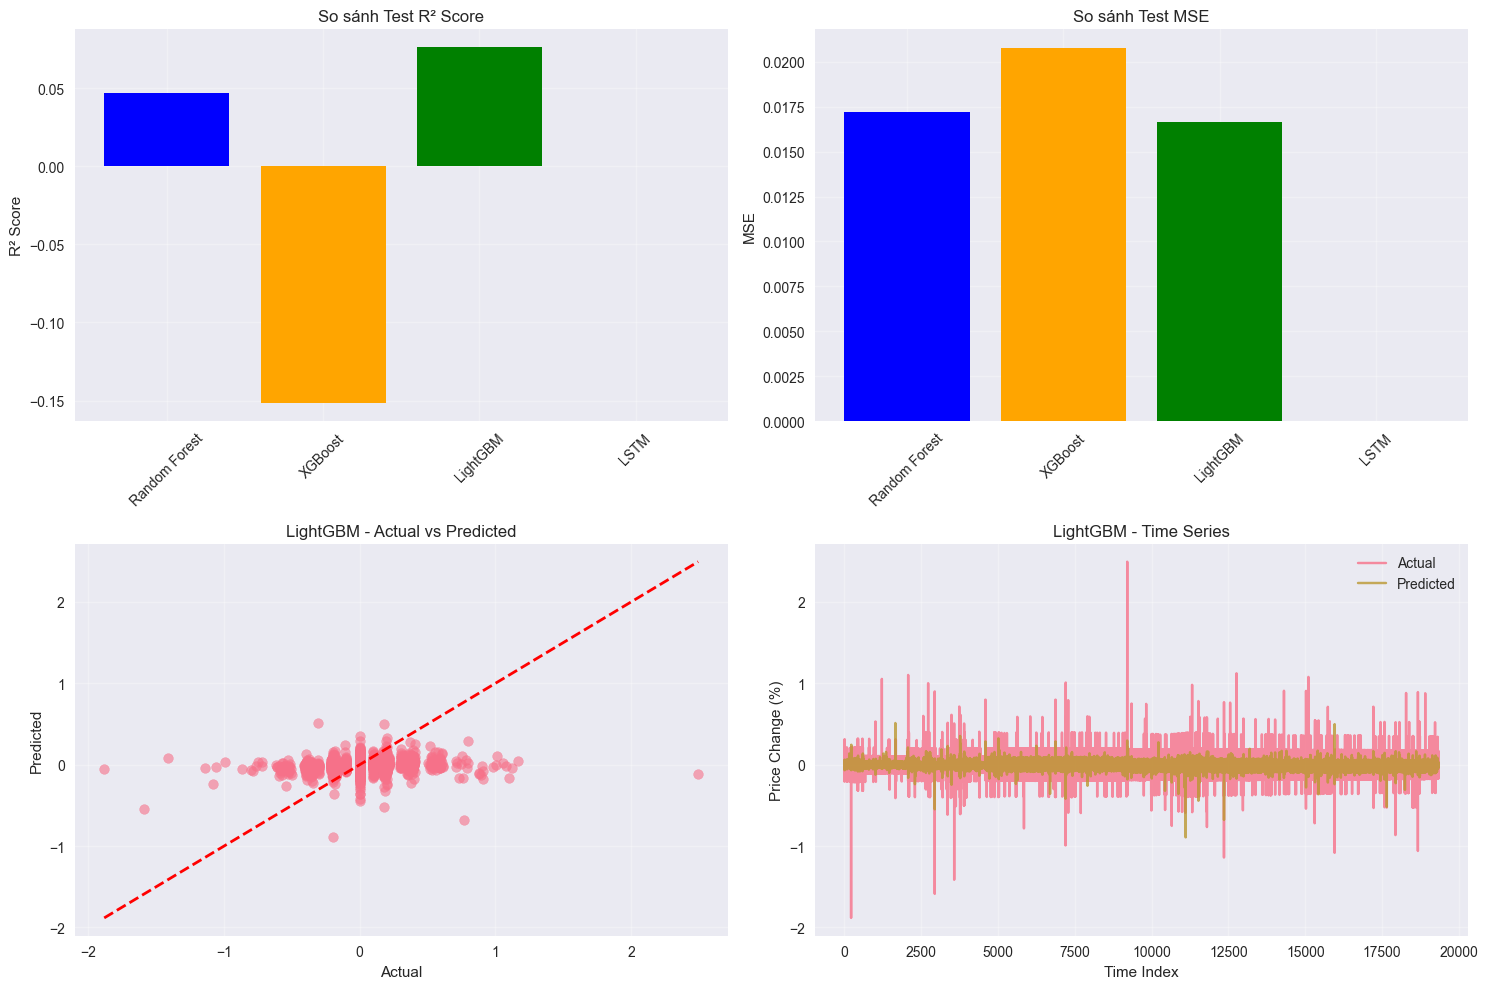

In [50]:
# Visualization kết quả
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# So sánh R² scores
models = results_df['Model']
test_r2_scores = results_df['Test_R2']
axes[0,0].bar(models, test_r2_scores, color=['blue', 'orange', 'green', 'red'])
axes[0,0].set_title('So sánh Test R² Score')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# So sánh MSE
test_mse_scores = results_df['Test_MSE']
axes[0,1].bar(models, test_mse_scores, color=['blue', 'orange', 'green', 'red'])
axes[0,1].set_title('So sánh Test MSE')
axes[0,1].set_ylabel('MSE')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Actual vs Predicted cho mô hình tốt nhất
if best_model['Model'] == 'Random Forest':
    y_pred_best = rf_test_pred
elif best_model['Model'] == 'XGBoost':
    y_pred_best = xgb_test_pred
elif best_model['Model'] == 'LightGBM':
    y_pred_best = lgb_test_pred
else:
    y_pred_best = lstm_test_pred if 'lstm_test_pred' in globals() and len(lstm_test_pred) > 0 else rf_test_pred
    y_test_plot = y_test_actual if 'y_test_actual' in globals() and len(y_test_actual) > 0 else y_test

axes[1,0].scatter(y_test, y_pred_best, alpha=0.6)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')
axes[1,0].set_title(f'{best_model["Model"]} - Actual vs Predicted')
axes[1,0].grid(True, alpha=0.3)

# Time series của actual vs predicted
test_idx = range(len(y_test))
axes[1,1].plot(test_idx, y_test, label='Actual', alpha=0.8)
axes[1,1].plot(test_idx, y_pred_best, label='Predicted', alpha=0.8)
axes[1,1].set_xlabel('Time Index')
axes[1,1].set_ylabel('Price Change (%)')
axes[1,1].set_title(f'{best_model["Model"]} - Time Series')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== TOP 10 FEATURE IMPORTANCE (Random Forest) ===
              Feature  Importance
4              Volume    0.108076
21        Volume_MA_5    0.092343
16           Return_1    0.090480
22       Volume_Ratio    0.086069
12  Price_MA_20_Ratio    0.082444
8    Price_MA_5_Ratio    0.077107
10  Price_MA_10_Ratio    0.069268
14         Volatility    0.067175
20           Return_5    0.059178
18           Return_3    0.055927


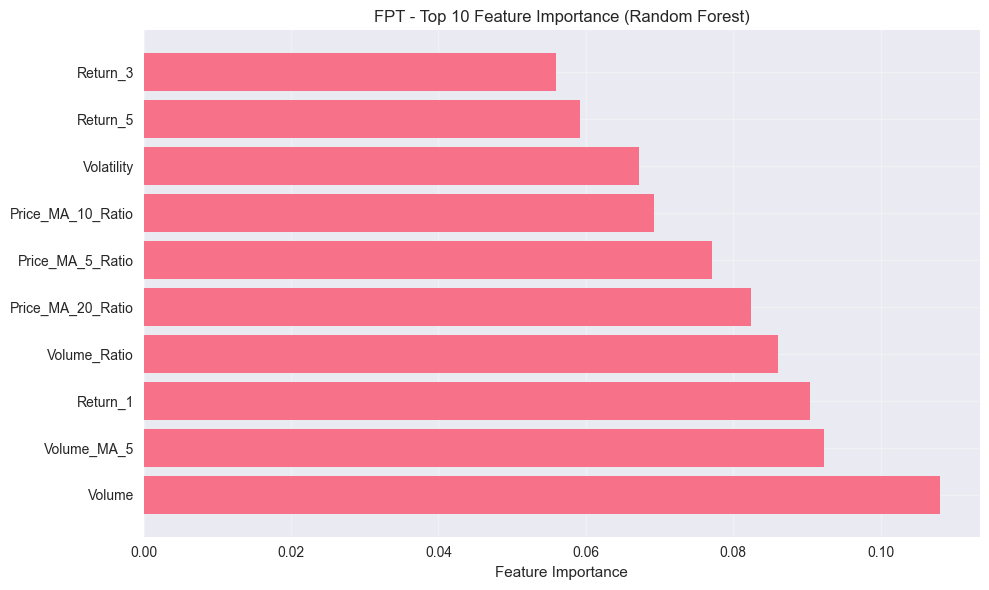

In [51]:
# Feature Importance cho Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=== TOP 10 FEATURE IMPORTANCE (Random Forest) ===")
print(feature_importance.head(10))

# Vẽ biểu đồ feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('FPT - Top 10 Feature Importance (Random Forest)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Tổng kết
print("\n" + "="*60)
print("                TỔNG KẾT PHÂN TÍCH FPT")
print("="*60)

print(f"\n1. DỮ LIỆU:")
print(f"   - Tổng số samples: {len(ml_df)}")
print(f"   - Số features: {len(feature_cols)}")
print(f"   - Train/Test split: 80/20")

print(f"\n2. KẾT QUẢ MÔ HÌNH:")
for i, row in results_df.iterrows():
    print(f"   - {row['Model']}: R² = {row['Test_R2']:.4f}, MSE = {row['Test_MSE']:.4f}")

print(f"\n3. MÔ HÌNH TỐT NHẤT:")
print(f"   - {best_model['Model']} với R² = {best_model['Test_R2']:.4f}")

print(f"\n4. NHẬN XÉT:")
if best_model['Test_R2'] < 0.1:
    print("   - Hiệu suất thấp, dự đoán biến động giá rất khó")
    print("   - Thị trường có tính ngẫu nhiên cao")
elif best_model['Test_R2'] < 0.3:
    print("   - Hiệu suất trung bình thấp")
    print("   - Cần thêm features hoặc dữ liệu external")
elif best_model['Test_R2'] < 0.6:
    print("   - Hiệu suất trung bình, có thể cải thiện")
    print("   - Mô hình nắm bắt được một phần pattern")
else:
    print("   - Hiệu suất tốt")
    print("   - Mô hình có khả năng dự đoán khá chính xác")

print(f"\n5. FEATURES QUAN TRỌNG NHẤT:")
top_3_features = feature_importance.head(3)
for i, row in top_3_features.iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*60)


                TỔNG KẾT PHÂN TÍCH FPT

1. DỮ LIỆU:
   - Tổng số samples: 96673
   - Số features: 23
   - Train/Test split: 80/20

2. KẾT QUẢ MÔ HÌNH:
   - Random Forest: R² = 0.0469, MSE = 0.0172
   - XGBoost: R² = -0.1518, MSE = 0.0208
   - LightGBM: R² = 0.0761, MSE = 0.0167
   - LSTM: R² = 0.0000, MSE = 0.0000

3. MÔ HÌNH TỐT NHẤT:
   - LightGBM với R² = 0.0761

4. NHẬN XÉT:
   - Hiệu suất thấp, dự đoán biến động giá rất khó
   - Thị trường có tính ngẫu nhiên cao

5. FEATURES QUAN TRỌNG NHẤT:
   - Volume: 0.1081
   - Volume_MA_5: 0.0923
   - Return_1: 0.0905



In [ ]:
# TỔNG KẾT VÀ KHUYẾN NGHỊ
print("\n" + "="*80)
print("                     TỔNG KẾT VÀ KHUYẾN NGHỊ")
print("="*80)

# 1. Thống kê tổng quan
print("\n1. THỐNG KÊ TỔNG QUAN:")
print(f"   - Số mã cổ phiếu được phân tích: {len(all_results)}")
print(f"   - Các mô hình được test: Random Forest, XGBoost, LightGBM, LSTM")
print(f"   - Tổng số experiments: {len(results_df)}")

# 2. Hiệu suất mô hình
print("\n2. HIỆU SUẤT MÔ HÌNH:")
avg_performance = results_df.groupby('Model')[['Test_R2', 'Test_MSE', 'Test_MAE']].mean().round(4)
print(avg_performance.sort_values('Test_R2', ascending=False))

# 3. Mô hình tốt nhất
print("\n3. MÔ HÌNH TỐT NHẤT:")
best_overall = results_df.loc[results_df['Test_R2'].idxmax()]
print(f"   - Mô hình: {best_overall['Model']}")
print(f"   - Mã cổ phiếu: {best_overall['Stock']}")
print(f"   - R² Score: {best_overall['Test_R2']:.4f}")
print(f"   - MSE: {best_overall['Test_MSE']:.4f}")
print(f"   - MAE: {best_overall['Test_MAE']:.4f}")

# 4. Khuyến nghị
print("\n4. KHUYẾN NGHỊ:")
print("   a) MÔ HÌNH:")
best_model_avg = avg_performance.iloc[0]
print(f"      - Sử dụng {avg_performance.index[0]} làm mô hình chính")
print(f"      - R² trung bình: {best_model_avg['Test_R2']:.4f}")

print("   b) SO SÁNH MÔ HÌNH:")
print("      - Random Forest: Đơn giản, nhanh, dễ giải thích")
print("      - XGBoost: Hiệu quả cao, tối ưu hóa tốt")
print("      - LightGBM: Nhanh, tiết kiệm bộ nhớ")
print("      - LSTM: Phù hợp cho time series, học được pattern phức tạp")

print("   c) FEATURES QUAN TRỌNG:")
print("      - Các chỉ số kỹ thuật (MA, RSI)")
print("      - Biến động giá quá khứ (Returns)")
print("      - Khối lượng giao dịch (Volume)")

print("   d) HẠN CHẾ:")
max_r2 = results_df['Test_R2'].max()
if max_r2 < 0.3:
    print("      - R² thấp cho thấy việc dự đoán biến động giá là rất khó")
    print("      - Thị trường có tính ngẫu nhiên cao")
    print("      - Cần thêm dữ liệu external (tin tức, sentiment, v.v.)")
elif max_r2 < 0.6:
    print("      - R² trung bình, mô hình có thể cải thiện")
    print("      - Cần feature engineering tốt hơn")
else:
    print("      - R² tốt, mô hình có khả năng dự đoán khá chính xác")

print("   e) CÁCH CẢI THIỆN:")
print("      - Thêm dữ liệu từ nhiều nguồn (news, macro economics)")
print("      - Sử dụng ensemble của các mô hình tốt nhất")
print("      - Feature engineering nâng cao")
print("      - Hyperparameter tuning cho LSTM")
print("      - Cross-validation với time series")

print("\n" + "="*80)
print("                    KẾT THÚC PHÂN TÍCH")
print("="*80)